In [28]:
import numpy as np
import itertools
import time
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

## Prepare the Ingredients

100%|██████████| 91/91 [00:03<00:00, 28.53it/s]


(271, 5)


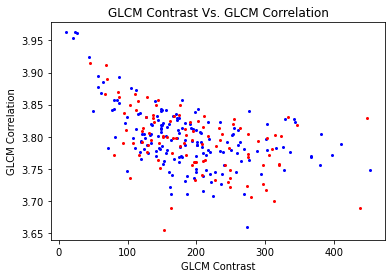

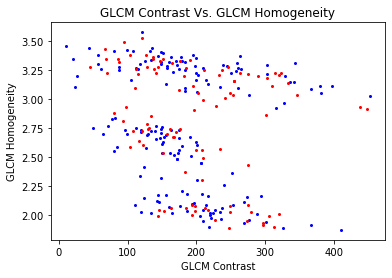

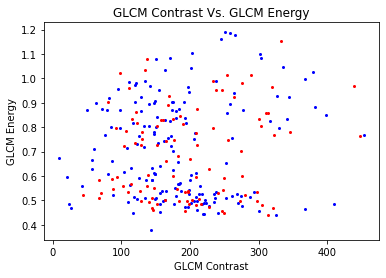

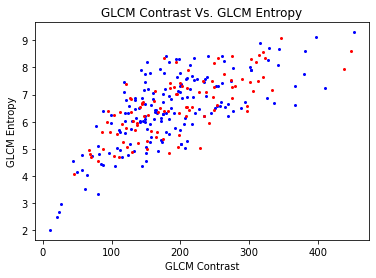

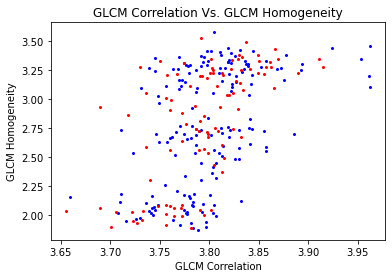

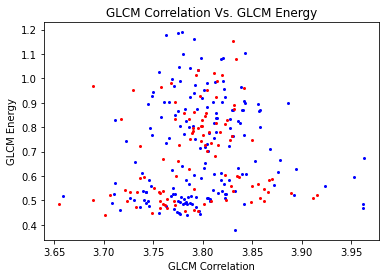

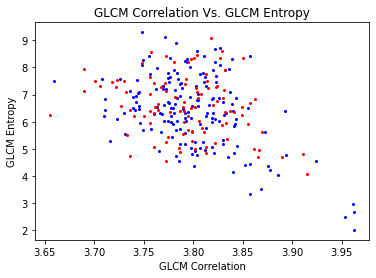

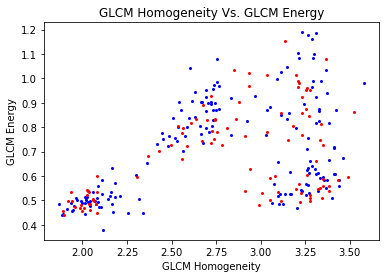

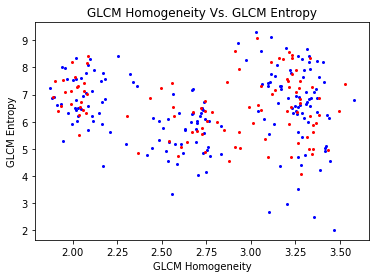

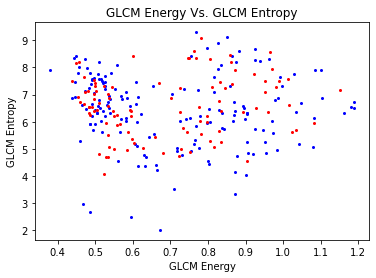

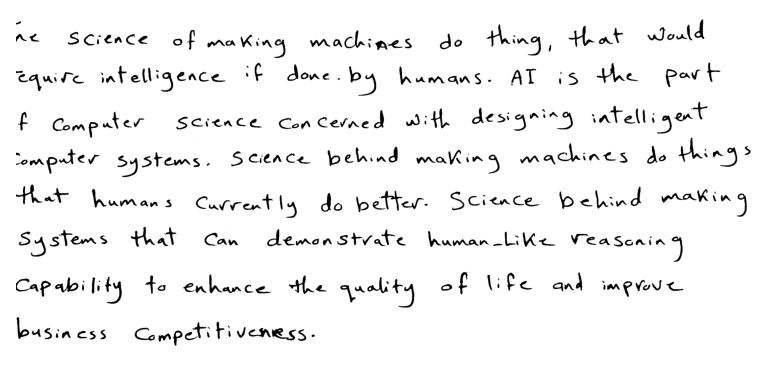

 At 0.9963099630996319756(271, 12) (271,)


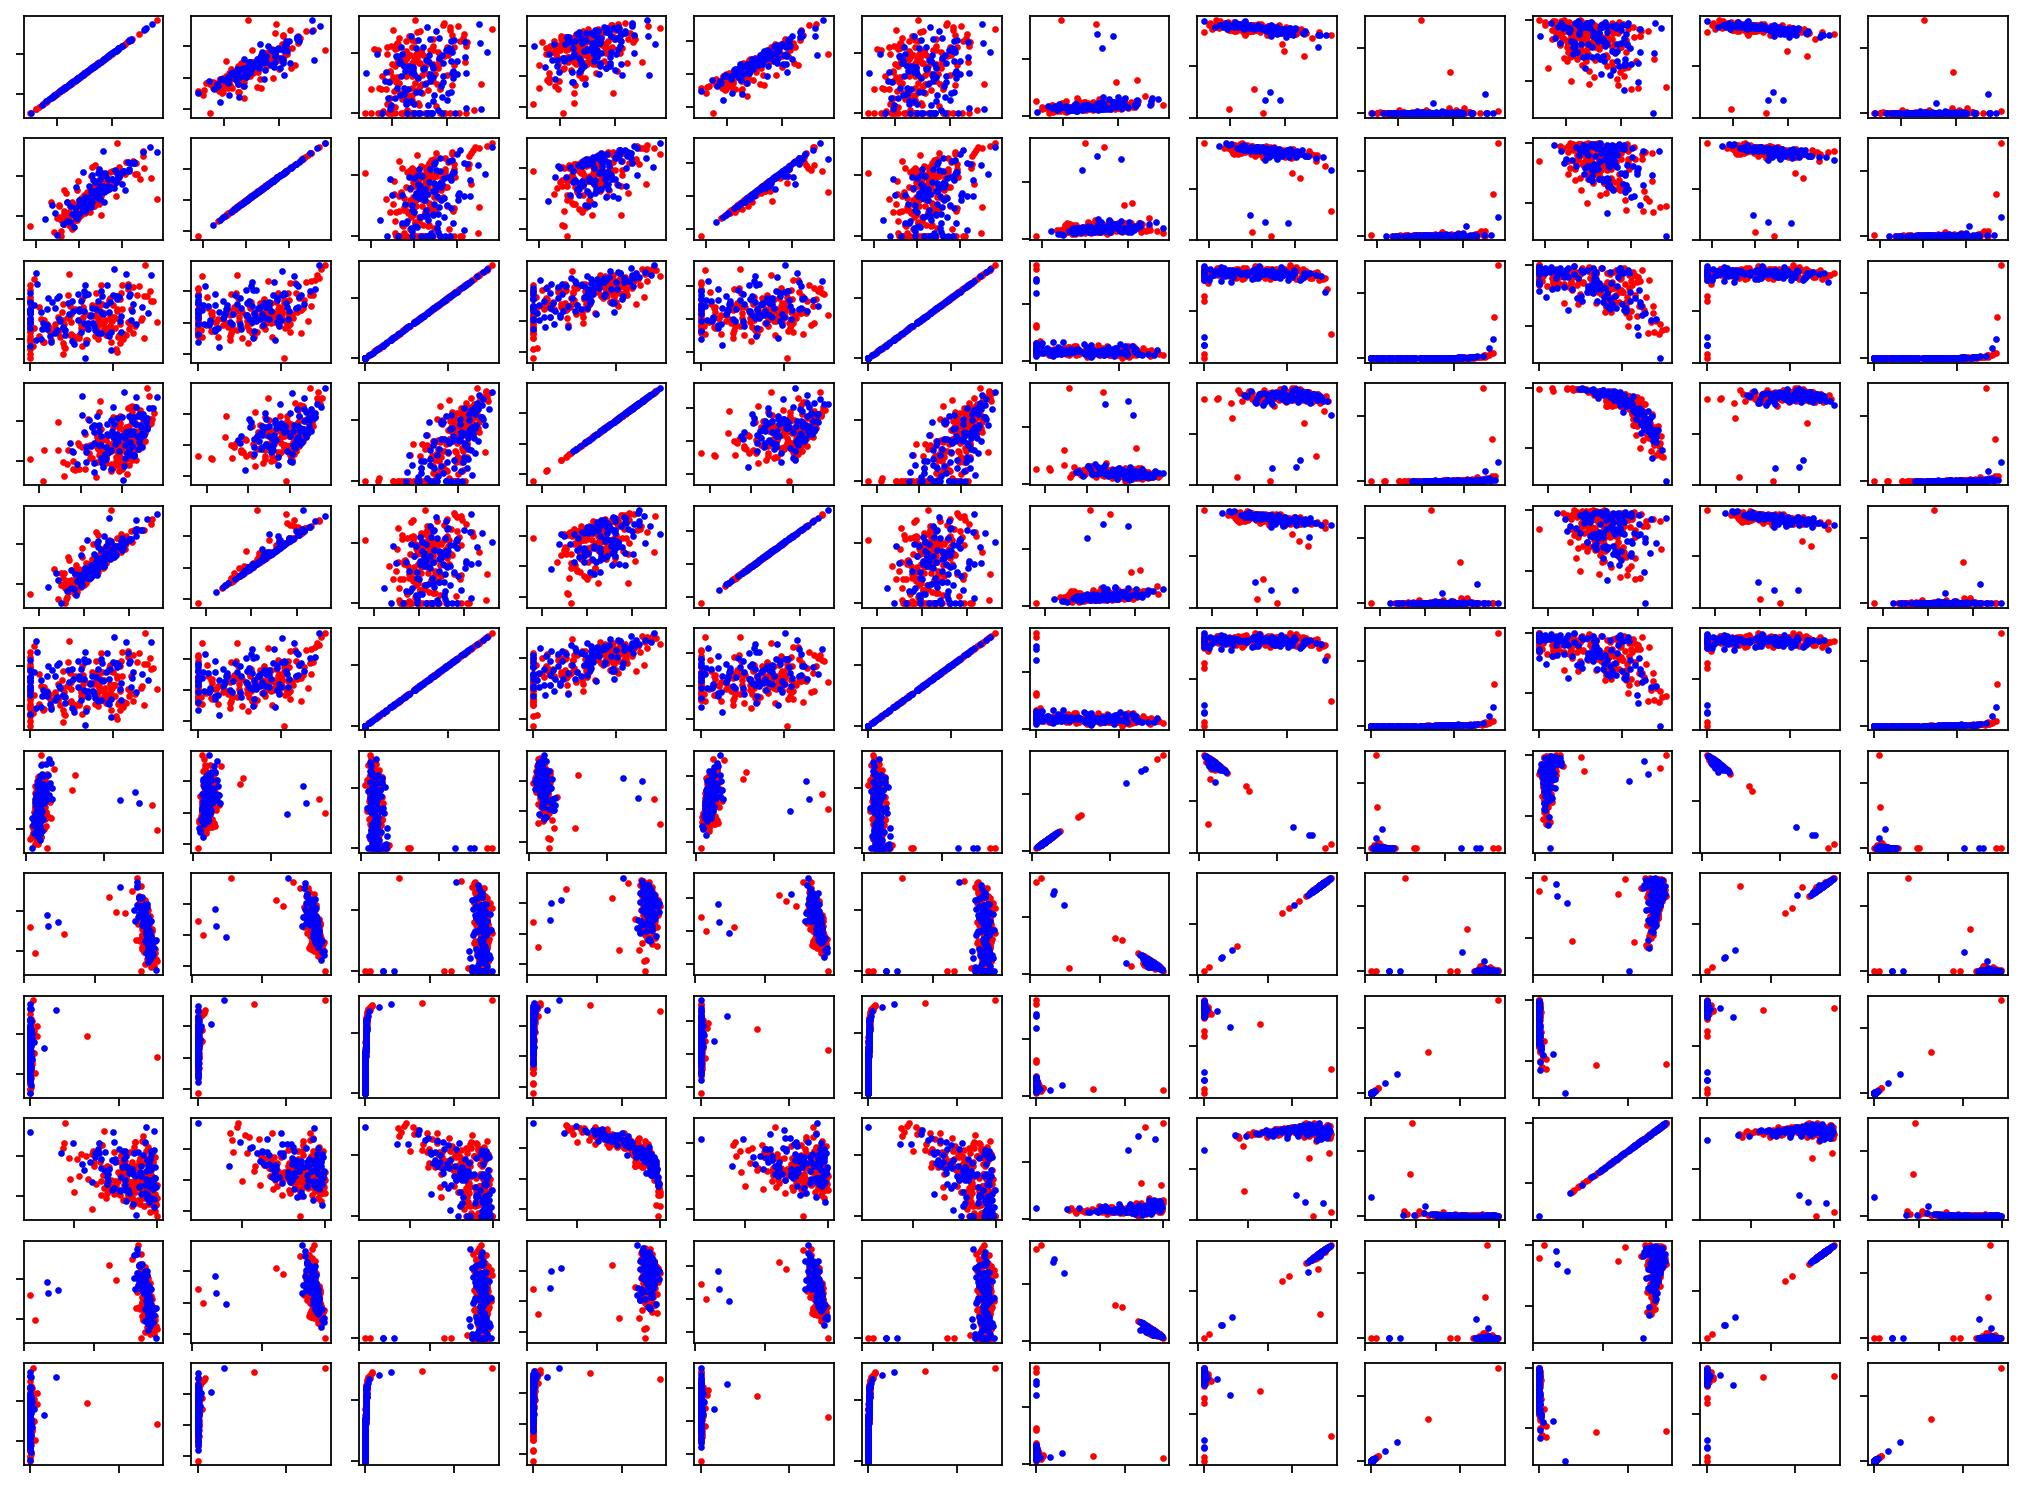

/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_26567/2694488313.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


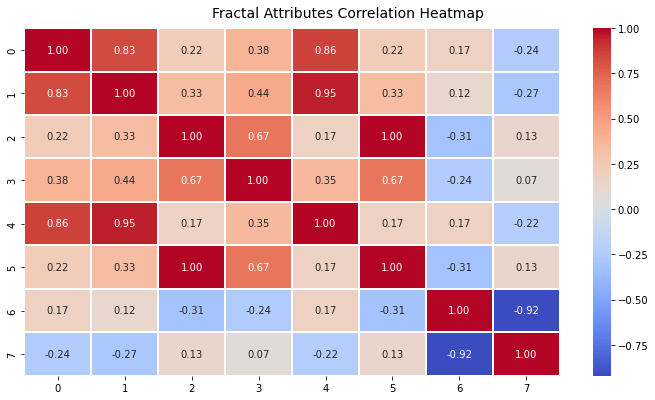

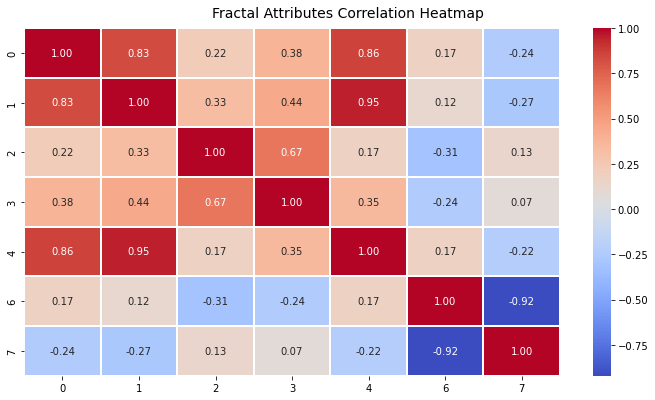

  0%|          | 0/271 [00:00<?, ?it/s]/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_26567/4150142401.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist,bins = np.histogram(img.ravel(),256,[0,256],True)
100%|██████████| 91/91 [00:52<00:00,  1.73it/s]

Features extraction is done, with the following training times:

COLD: 58.67229986190796s
HINGE: 66.1017849445343s
GLCM: 58.86677098274231s
Fractal: 166.69626307487488s
Hog: 20.99382972717285s
LBP: 209.44400000572205s




In [30]:
seed=np.random.randint(0,100)

np.random.seed(seed)
%run ../Preprocessing/Read_Data.ipynb
saved = False

times = []
if saved == True:
   with open('../Datasets/tuna.npy', 'rb') as f:
            x_data_COLD = np.load(f, allow_pickle=True)
            x_data_HINGE = np.load(f, allow_pickle=True)
            x_data_GLCM = np.load(f, allow_pickle=True)
            x_data_Fractal = np.load(f, allow_pickle=True)
            x_data_Hog = np.load(f, allow_pickle=True)
            x_data_LBP = np.load(f, allow_pickle=True)
            times = np.load(f, allow_pickle=True)
else:
   
   start = time.time()
   np.random.seed(seed)
   %run ../Features/FindCOLDFeatures.ipynb
   end = time.time()
   x_data_COLD = np.concatenate((x_train, x_test), axis=0)
   times.append(end - start)

   
   start = time.time()
   np.random.seed(seed)
   %run ../Features/FindHINGEFeatures.ipynb
   end = time.time()
   x_data_HINGE = np.concatenate((x_train, x_test), axis=0)
   times.append(end - start)

   np.random.seed(seed)
   start = time.time()
   np.random.seed(seed)
   %run ../Features/FindGLCMFeatures.ipynb
   end = time.time()
   x_data_GLCM = np.concatenate((x_train, x_test), axis=0)
   times.append(end - start)

   start = time.time()
   np.random.seed(seed)
   %run ../Features/FindFractalFeatures.ipynb
   end = time.time()
   x_data_Fractal = np.concatenate((x_train, x_test), axis=0)
   times.append(end - start)

   start = time.time()
   np.random.seed(seed)
   %run ../Features/FindHogFeatures.ipynb
   end = time.time()
   x_data_Hog = np.concatenate((x_train, x_test), axis=0)
   times.append(end - start)

   start = time.time()
   np.random.seed(seed)
   %run ../Features/FindLBPFeatures.ipynb
   end = time.time()
   x_data_LBP = np.concatenate((x_train, x_test), axis=0)
   times.append(end - start)

   with open('../Datasets/tuna.npy', 'wb') as f:
            np.save(f, x_data_COLD, allow_pickle=True)
            np.save(f, x_data_HINGE, allow_pickle=True)
            np.save(f, x_data_GLCM, allow_pickle=True)
            np.save(f, x_data_Fractal, allow_pickle=True)
            np.save(f, x_data_Hog, allow_pickle=True)
            np.save(f, x_data_LBP, allow_pickle=True)
            np.save(f, times, allow_pickle=True)
          

print(f"""Features extraction is done, with the following training times:

COLD: {times[0]}s
HINGE: {times[1]}s
GLCM: {times[2]}s
Fractal: {times[3]}s
Hog: {times[4]}s
LBP: {times[5]}s

""")

## Mixing Time!

In [31]:
x_datas = []
y_data = np.concatenate((y_train, y_test), axis=0)

combinations = list(itertools.product([0, 1], repeat=6))
empty = [[] for _ in range(len(x_data_COLD))]
for i in range(len(combinations)):
      if i != 0:
            x_datas.append(np.concatenate((
            x_data_COLD if combinations[i][0] == 1 else empty,
            x_data_HINGE if combinations[i][1] == 1 else empty,
            x_data_GLCM if combinations[i][2] == 1 else empty,
            x_data_Fractal if combinations[i][3] == 1 else empty, 
            x_data_Hog if combinations[i][4] == 1 else empty, 
            x_data_LBP if combinations[i][5] == 1 else empty), axis=1))



## Taste Judge Getting Ready!

In [32]:
def CV(x_data, y_data, iterations,  model):
   accuracies = []
   for _ in tqdm(range(1, iterations+1)):
      p = np.random.permutation(len(x_data))
      x_data = x_data[p]
      y_data = y_data[p]
      if model == "SVM":   model = svm.SVC(C=6)
      elif model == "RF":  model = RandomForestClassifier(n_estimators=300)
      elif model == "GB":  model = GradientBoostingClassifier(n_estimators=300)
      elif model == "NN": model = MLPClassifier( hidden_layer_sizes=(int(x_data.shape[1] * 0.4), int(x_data.shape[1] * 0.2)), activation='relu', solver='adam', max_iter=500)
      scores = cross_val_score(model, x_data, y_data, cv=5)
      accuracies.append(scores.mean() * 100)
   accuracies = np.array(accuracies)
   return np.mean(accuracies)


## Tasting Time!

In [33]:
Performances = []
for x_data in tqdm(x_datas):
   Performances.append(CV(x_data, y_data, 1, model='SVM'))


100%|██████████| 63/63 [02:43<00:00,  2.59s/it]


In [65]:
features = ["COLD", "HINGE", "GLCM", "Fractal", "Hog", "LBP"]
def decode_combination(index):
   code = '{0:06b}'.format(index+1)
   str = "The corresponding feature set had features:"
   for i in range(len(code)):
      if code[i] == '1':
         str += (f" {features[i]}")
   str += '.'
   return str

print(decode_combination(np.argmax(Performances)))


The corresponding feature set had features: HINGE.


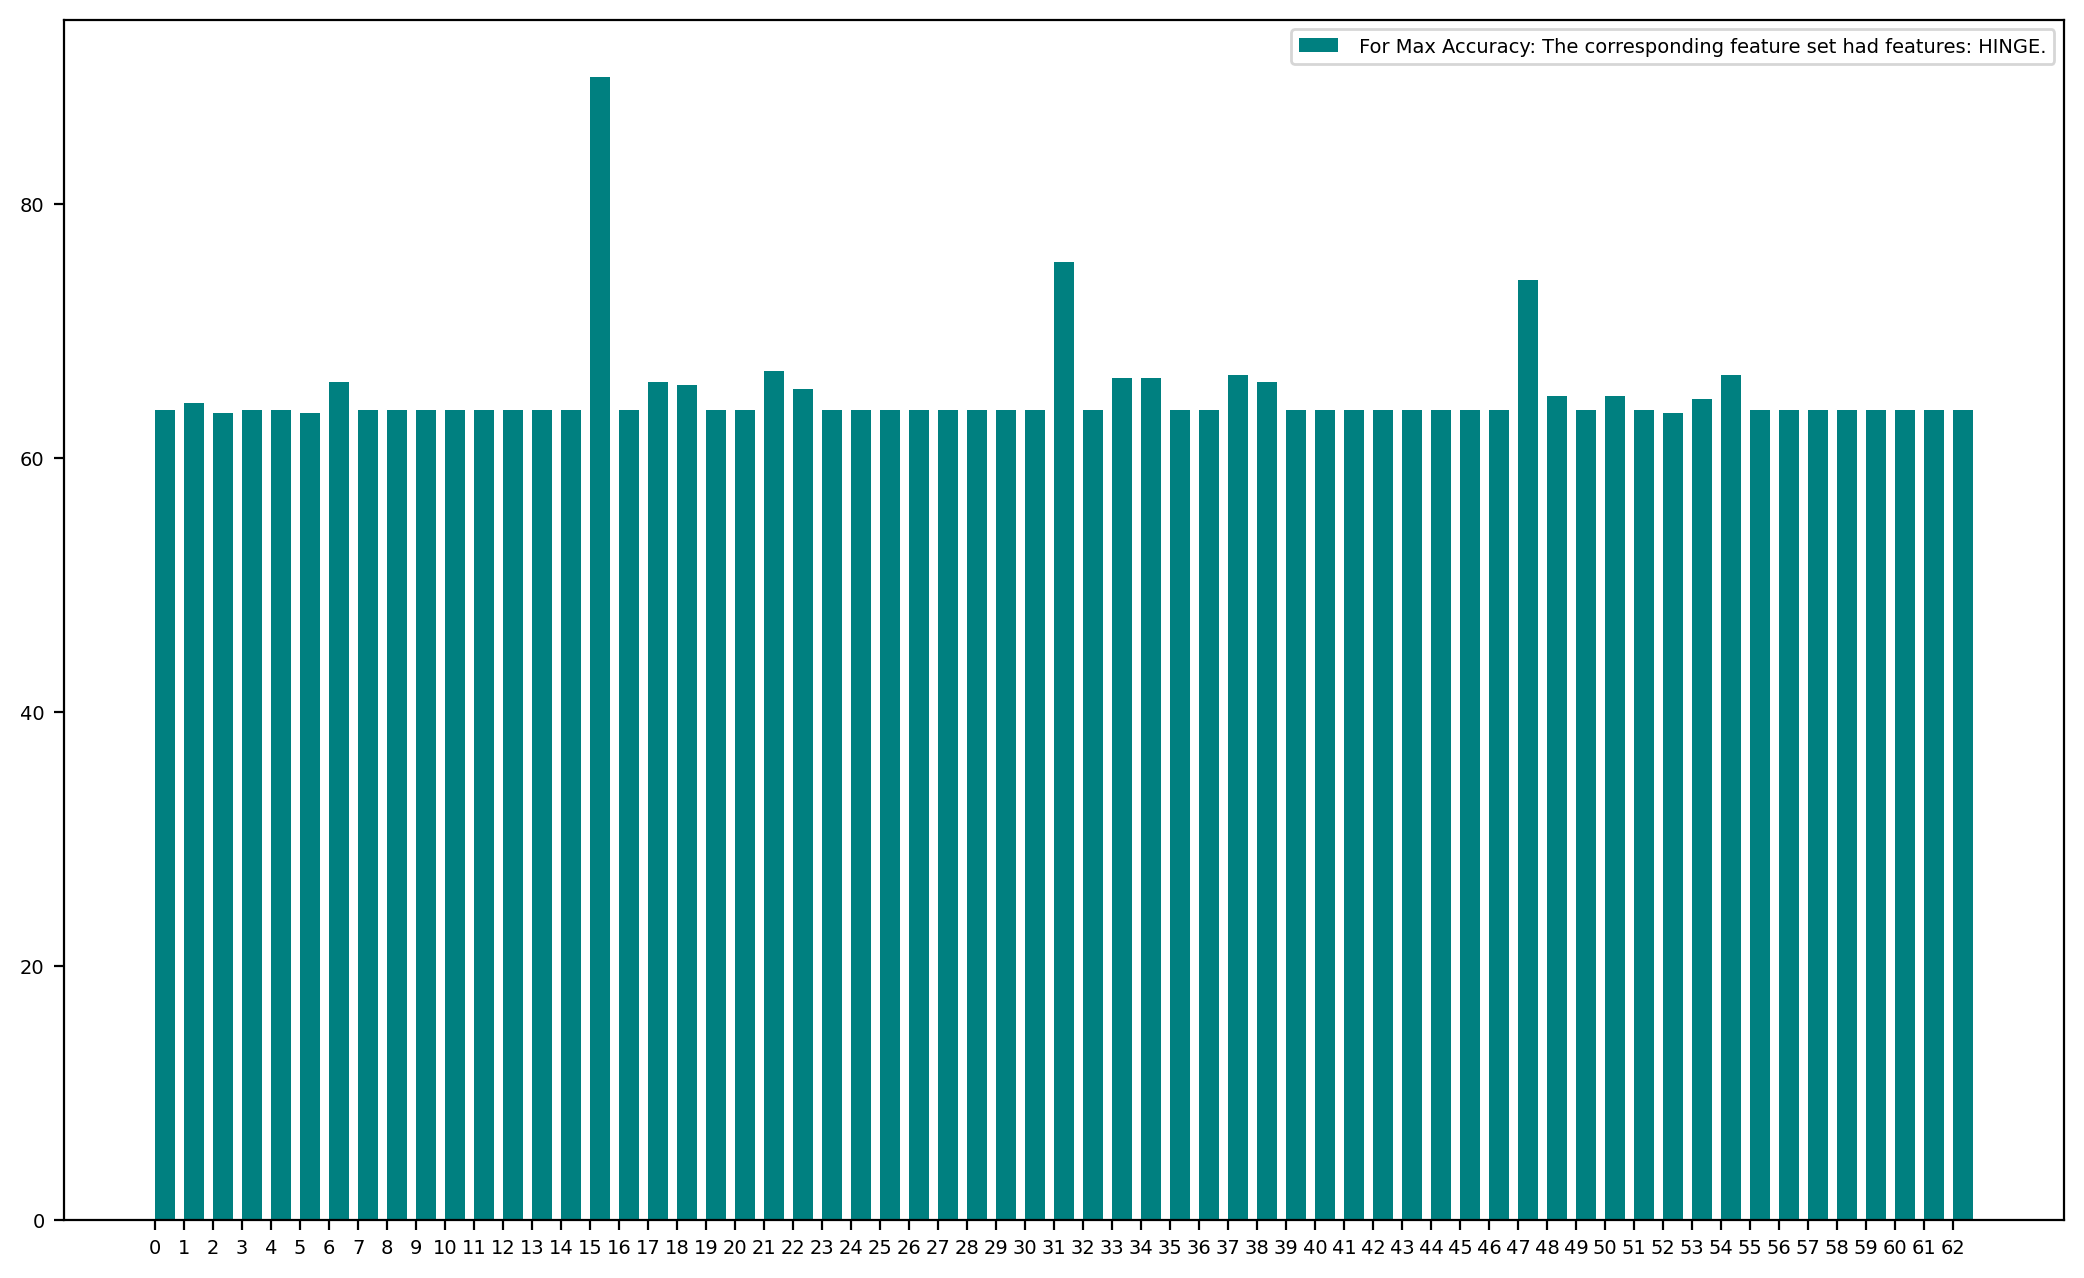

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure(dpi=200, figsize=(10, 6))
plt.rcParams.update({'font.size': 7})
ax = fig.add_axes([0,0,1,1])
labels = [ str(i) for i in range(len(Performances))]
ax.bar(labels,Performances, align='edge', color='teal', width=0.7, label=" For Max Accuracy: "+ decode_combination(np.argmax(Performances)))
ax.legend(loc="upper right")
plt.show()
